# 台中市都市犯罪分析：竊盜案件探索性資料分析

**課程名稱**：計算思維與人工智慧  
**研究題目**：台中市都市犯罪分析：以 AI 輔助打造安全永續城市

---

## SDG 永續發展目標連結

- **SDG 11 永續城市與社區**：透過互動式治安風險地圖與安全路線建議，協助民眾做出更安全的生活與旅遊選擇
- **SDG 16 和平、正義及健全制度**：將公開治安數據轉換為易於理解的安全指標，強化政府資料開放的實際應用

---

## 目錄
1. 資料讀取與初步檢視
2. 資料清理與欄位標準化
3. 加入行政區欄位
4. 合併所有竊盜資料
5. 時間趨勢分析
6. 行政區犯罪分布分析
7. 行政區每萬人竊盜率分析（人口校正）
8. 官方近5年指標對照
9. 結論與發現

## 1. 資料讀取與初步檢視

**目的**：讀取 105-108 年台中市四種竊盜資料，確認資料結構

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# 設定中文字型
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft JhengHei', 'Heiti TC']
plt.rcParams['axes.unicode_minus'] = False

warnings.filterwarnings('ignore')

# 設定路徑
RAW_DIR = Path('../data/raw')
PROCESSED_DIR = Path('../data/processed')
FIGURES_DIR = Path('../outputs/figures')

print('環境設定完成！')

環境設定完成！


In [2]:
# 讀取所有 CSV 檔案
crime_types = {
    'scooter_theft': '機車竊盜',
    'car_theft': '汽車竊盜',
    'residential_burglary': '住宅竊盜',
    'bike_theft': '自行車竊盜'
}

years = ['105', '106', '107', '108']

# 儲存所有資料集
datasets = {}

for crime_key, crime_name in crime_types.items():
    dfs = []
    for year in years:
        file_path = RAW_DIR / f'{crime_key}_{year}.csv'
        if file_path.exists():
            df = pd.read_csv(file_path, encoding='utf-8-sig')
            df['year_file'] = year
            dfs.append(df)
            print(f'讀取 {crime_name} {year} 年：{len(df)} 筆')
    
    if dfs:
        datasets[crime_key] = pd.concat(dfs, ignore_index=True)
        print(f'=> {crime_name} 總計：{len(datasets[crime_key])} 筆\n')

讀取 機車竊盜 105 年：467 筆
讀取 機車竊盜 106 年：503 筆
讀取 機車竊盜 107 年：320 筆
讀取 機車竊盜 108 年：85 筆
=> 機車竊盜 總計：1375 筆

讀取 汽車竊盜 105 年：248 筆
讀取 汽車竊盜 106 年：184 筆
讀取 汽車竊盜 107 年：145 筆
讀取 汽車竊盜 108 年：59 筆
=> 汽車竊盜 總計：636 筆

讀取 住宅竊盜 105 年：241 筆
讀取 住宅竊盜 106 年：237 筆
讀取 住宅竊盜 107 年：192 筆
讀取 住宅竊盜 108 年：48 筆
=> 住宅竊盜 總計：718 筆

讀取 自行車竊盜 105 年：187 筆
讀取 自行車竊盜 106 年：178 筆
讀取 自行車竊盜 107 年：135 筆
讀取 自行車竊盜 108 年：57 筆
=> 自行車竊盜 總計：557 筆



In [3]:
# 檢視資料結構
print('=== 機車竊盜資料範例 ===')
print(datasets['scooter_theft'].head())
print('\n欄位：', datasets['scooter_theft'].columns.tolist())
print('資料型態：\n', datasets['scooter_theft'].dtypes)

=== 機車竊盜資料範例 ===
   編號    案類     發生日期  發生時間           發生地點 year_file
0   1  機車竊盜  1050102  1530  臺中市神岡區福庄街168巷       105
1   2  機車竊盜  1050104  1715   臺中市北區五權路和英士路       105
2   3  機車竊盜  1050109  1730  臺中市清水區港口路202巷       105
3   4  機車竊盜  1050109  2320       臺中市南區南平路       105
4   5  機車竊盜  1050111  1840    臺中市和平區東關路1段       105

欄位： ['編號', '案類', '發生日期', '發生時間', '發生地點', 'year_file']
資料型態：
 編號            int64
案類           object
發生日期          int64
發生時間          int64
發生地點         object
year_file    object
dtype: object


## 2. 資料清理與欄位標準化

**目的**：統一欄位名稱、轉換日期時間格式、處理缺失值

In [4]:
def clean_crime_data(df, crime_category):
    """
    清理犯罪資料，標準化欄位名稱
    
    參數:
        df: 原始 DataFrame
        crime_category: 犯罪類型名稱
    
    回傳:
        清理後的 DataFrame
    """
    df_clean = df.copy()
    
    # 重新命名欄位
    df_clean = df_clean.rename(columns={
        '發生日期': 'date_raw',
        '發生時間': 'time_raw',
        '發生地點': 'location'
    })
    
    # 轉換民國年日期為西元年
    def convert_roc_date(date_val):
        try:
            date_str = str(int(date_val)).zfill(7)  # 確保是 7 位數
            roc_year = int(date_str[:3])
            month = int(date_str[3:5])
            day = int(date_str[5:7])
            western_year = roc_year + 1911
            return pd.Timestamp(year=western_year, month=month, day=day)
        except:
            return pd.NaT
    
    df_clean['date'] = df_clean['date_raw'].apply(convert_roc_date)
    
    # 轉換時間為小時
    def extract_hour(time_val):
        try:
            time_str = str(int(time_val)).zfill(4)
            return int(time_str[:2])
        except:
            return -1
    
    df_clean['hour'] = df_clean['time_raw'].apply(extract_hour)
    
    # 新增犯罪類型欄位
    df_clean['crime_category'] = crime_category
    
    # 檢查有效性
    df_clean['is_valid'] = 1
    df_clean.loc[df_clean['date'].isna(), 'is_valid'] = 0
    df_clean.loc[df_clean['location'].isna(), 'is_valid'] = 0
    df_clean.loc[df_clean['hour'] < 0, 'is_valid'] = 0
    
    return df_clean

print('清理函式定義完成！')

清理函式定義完成！


In [5]:
# 清理所有資料集
cleaned_datasets = {}

for crime_key, crime_name in crime_types.items():
    if crime_key in datasets:
        cleaned_datasets[crime_key] = clean_crime_data(datasets[crime_key], crime_name)
        
        # 統計有效資料
        valid_count = cleaned_datasets[crime_key]['is_valid'].sum()
        total_count = len(cleaned_datasets[crime_key])
        print(f'{crime_name}：{valid_count}/{total_count} 筆有效 ({valid_count/total_count*100:.1f}%)')

# 檢視清理後的資料
print('\n=== 清理後的機車竊盜資料範例 ===')
print(cleaned_datasets['scooter_theft'][['date', 'hour', 'location', 'crime_category', 'is_valid']].head())

機車竊盜：1375/1375 筆有效 (100.0%)
汽車竊盜：636/636 筆有效 (100.0%)
住宅竊盜：718/718 筆有效 (100.0%)
自行車竊盜：557/557 筆有效 (100.0%)

=== 清理後的機車竊盜資料範例 ===
        date  hour       location crime_category  is_valid
0 2016-01-02    15  臺中市神岡區福庄街168巷           機車竊盜         1
1 2016-01-04    17   臺中市北區五權路和英士路           機車竊盜         1
2 2016-01-09    17  臺中市清水區港口路202巷           機車竊盜         1
3 2016-01-09    23       臺中市南區南平路           機車竊盜         1
4 2016-01-11    18    臺中市和平區東關路1段           機車竊盜         1


## 3. 加入行政區欄位

**目的**：從地點文字中解析行政區，用於後續的區域分析

In [6]:
# 台中市 29 個行政區
TAICHUNG_DISTRICTS = [
    '中區', '東區', '西區', '南區', '北區',
    '西屯區', '北屯區', '南屯區',
    '豐原區', '大里區', '太平區', '清水區', '沙鹿區',
    '大甲區', '東勢區', '梧棲區', '烏日區', '神岡區',
    '大肚區', '大雅區', '后里區', '霧峰區', '潭子區',
    '龍井區', '外埔區', '和平區', '石岡區', '大安區', '新社區'
]

def extract_district(location):
    """
    從地點文字中提取行政區
    """
    if pd.isna(location):
        return '未知'
    
    location = str(location)
    
    for district in TAICHUNG_DISTRICTS:
        if district in location:
            return district
    
    return '其他'

# 對所有資料集加入行政區欄位
for crime_key in cleaned_datasets:
    cleaned_datasets[crime_key]['district'] = cleaned_datasets[crime_key]['location'].apply(extract_district)

print('行政區欄位新增完成！')

行政區欄位新增完成！


In [7]:
# 檢視行政區分布
all_districts = []
for crime_key in cleaned_datasets:
    all_districts.extend(cleaned_datasets[crime_key]['district'].tolist())

district_counts = pd.Series(all_districts).value_counts()
print('行政區資料量分布：')
print(district_counts)

行政區資料量分布：
西屯區    344
北區     331
北屯區    267
豐原區    229
東區     192
大里區    186
南區     164
西區     162
太平區    160
南屯區    150
大雅區    108
烏日區    105
中區     105
潭子區     97
龍井區     83
沙鹿區     82
神岡區     80
清水區     79
大甲區     73
霧峰區     73
梧棲區     53
大肚區     45
后里區     36
東勢區     31
外埔區     17
新社區     15
大安區      8
石岡區      6
和平區      5
Name: count, dtype: int64


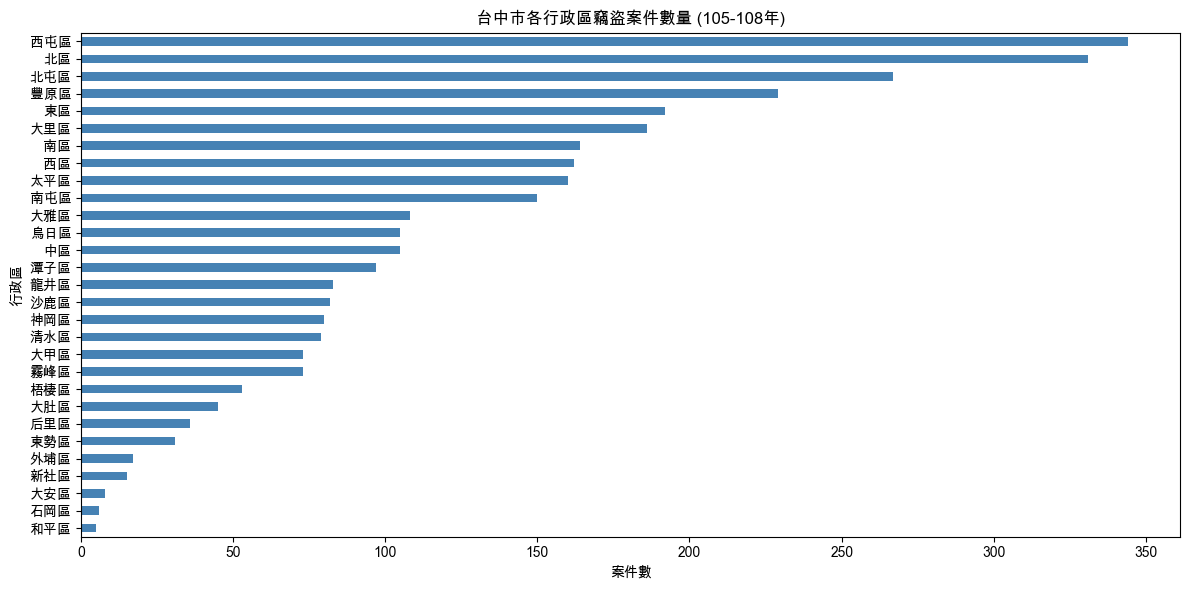

圖表已儲存至 ../outputs/figures/district_case_count.png


In [8]:
# 繪製行政區資料量長條圖
fig, ax = plt.subplots(figsize=(12, 6))

# 排除「其他」和「未知」
valid_districts = district_counts[~district_counts.index.isin(['其他', '未知'])]
valid_districts = valid_districts.sort_values(ascending=True)

valid_districts.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('案件數')
ax.set_ylabel('行政區')
ax.set_title('台中市各行政區竊盜案件數量 (105-108年)')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'district_case_count.png', dpi=150)
plt.show()

print(f'圖表已儲存至 {FIGURES_DIR / "district_case_count.png"}')

## 4. 合併所有竊盜資料

**目的**：將四種竊盜資料合併為一張總表，方便後續分析

In [9]:
# 選擇需要的欄位並合併
columns_to_keep = ['date', 'hour', 'location', 'district', 'crime_category', 'is_valid']

all_theft_data = pd.concat(
    [cleaned_datasets[key][columns_to_keep] for key in cleaned_datasets],
    ignore_index=True
)

print(f'合併後總資料筆數：{len(all_theft_data)}')
print('\n各犯罪類型件數分布：')
print(all_theft_data['crime_category'].value_counts())

合併後總資料筆數：3286

各犯罪類型件數分布：
crime_category
機車竊盜     1375
住宅竊盜      718
汽車竊盜      636
自行車竊盜     557
Name: count, dtype: int64


In [10]:
# 儲存清理後的資料
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# 儲存各類型資料
for crime_key, crime_name in crime_types.items():
    if crime_key in cleaned_datasets:
        output_path = PROCESSED_DIR / f'{crime_key}_cleaned.csv'
        cleaned_datasets[crime_key].to_csv(output_path, index=False, encoding='utf-8-sig')
        print(f'已儲存：{output_path}')

# 儲存合併後的總表
all_theft_data.to_csv(PROCESSED_DIR / 'taichung_theft_all.csv', index=False, encoding='utf-8-sig')
print(f'\n已儲存：{PROCESSED_DIR / "taichung_theft_all.csv"}')

已儲存：../data/processed/scooter_theft_cleaned.csv
已儲存：../data/processed/car_theft_cleaned.csv
已儲存：../data/processed/residential_burglary_cleaned.csv
已儲存：../data/processed/bike_theft_cleaned.csv

已儲存：../data/processed/taichung_theft_all.csv


## 5. 時間趨勢分析

**目的**：分析竊盜案件的年度趨勢、月份分布、時段分布

In [11]:
# 篩選有效資料
valid_data = all_theft_data[all_theft_data['is_valid'] == 1].copy()
valid_data['year'] = valid_data['date'].dt.year
valid_data['month'] = valid_data['date'].dt.month

print(f'有效資料筆數：{len(valid_data)}')

有效資料筆數：3286


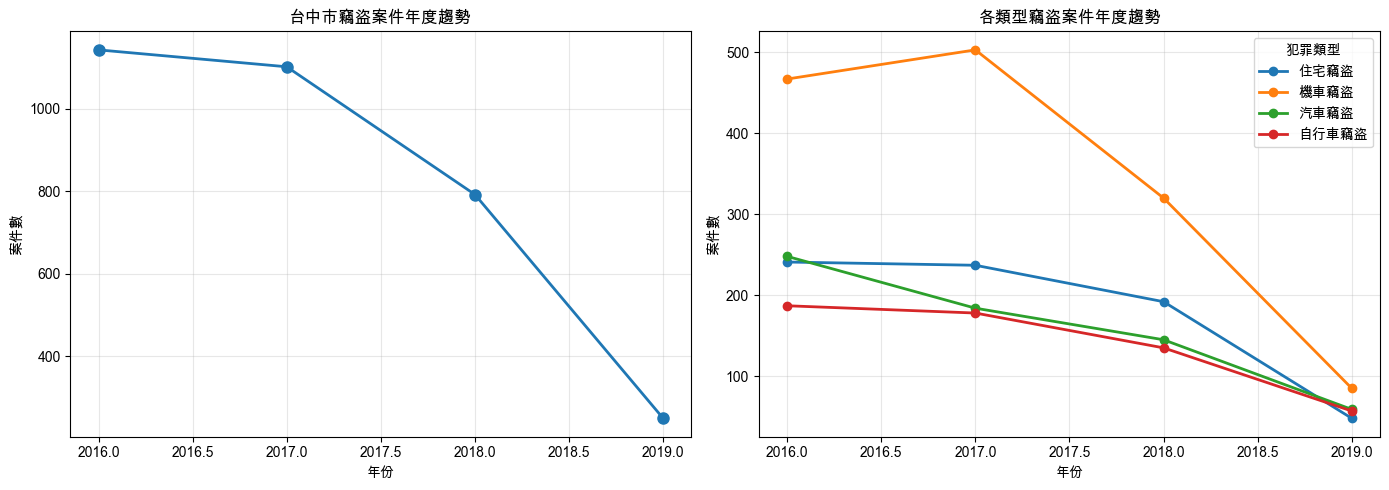

In [12]:
# 年度趨勢圖
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 總體年度趨勢
yearly_total = valid_data.groupby('year').size()
axes[0].plot(yearly_total.index, yearly_total.values, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('年份')
axes[0].set_ylabel('案件數')
axes[0].set_title('台中市竊盜案件年度趨勢')
axes[0].grid(True, alpha=0.3)

# 分類型年度趨勢
yearly_by_type = valid_data.groupby(['year', 'crime_category']).size().unstack(fill_value=0)
yearly_by_type.plot(ax=axes[1], marker='o', linewidth=2)
axes[1].set_xlabel('年份')
axes[1].set_ylabel('案件數')
axes[1].set_title('各類型竊盜案件年度趨勢')
axes[1].legend(title='犯罪類型', loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'theft_trend_by_year.png', dpi=150)
plt.show()

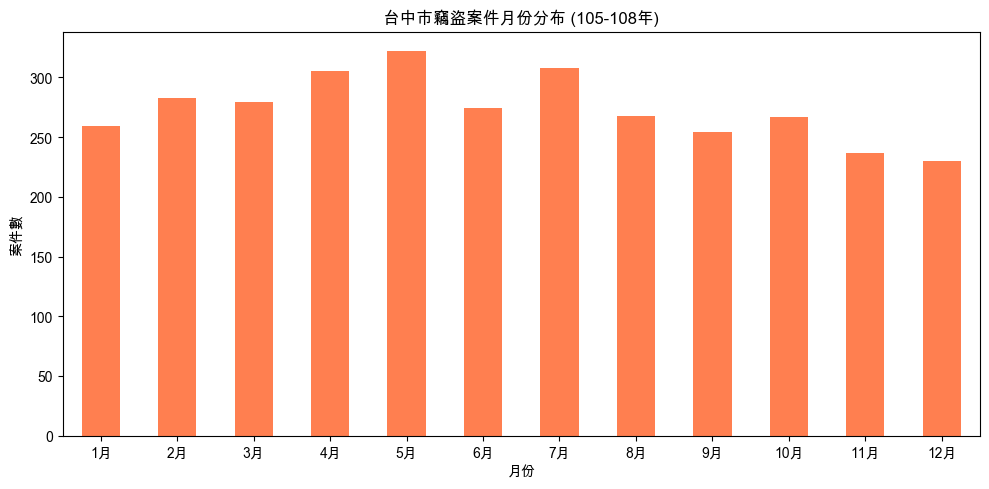

In [13]:
# 月份分布
fig, ax = plt.subplots(figsize=(10, 5))

monthly = valid_data.groupby('month').size()
monthly.plot(kind='bar', ax=ax, color='coral')
ax.set_xlabel('月份')
ax.set_ylabel('案件數')
ax.set_title('台中市竊盜案件月份分布 (105-108年)')
ax.set_xticklabels([f'{i}月' for i in range(1, 13)], rotation=0)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'theft_by_month.png', dpi=150)
plt.show()

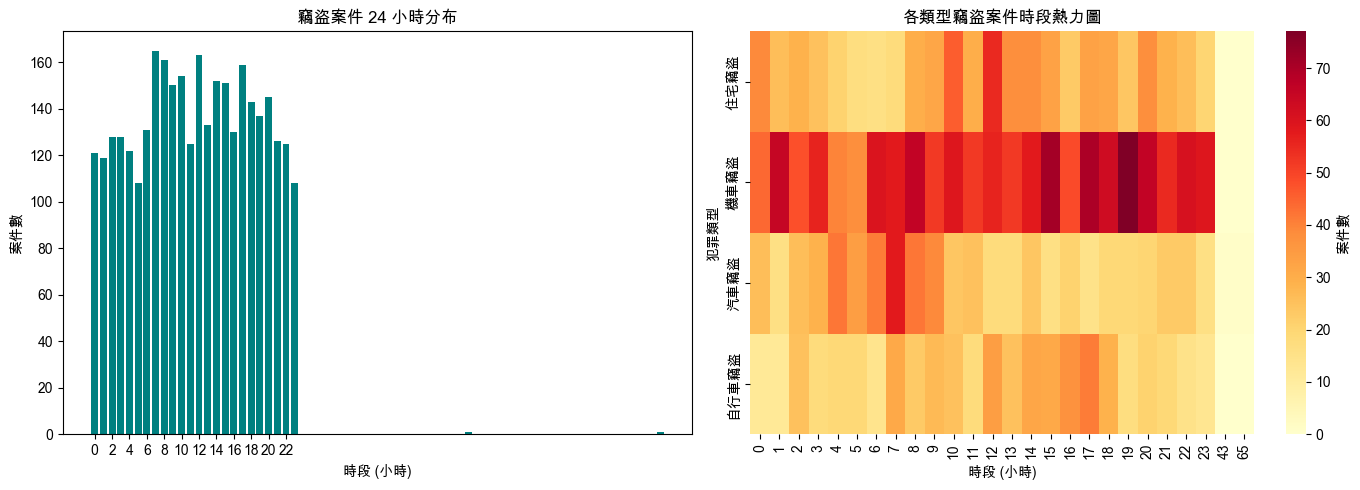

In [14]:
# 24小時時段分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 整體時段分布
hourly = valid_data[valid_data['hour'] >= 0].groupby('hour').size()
axes[0].bar(hourly.index, hourly.values, color='teal')
axes[0].set_xlabel('時段 (小時)')
axes[0].set_ylabel('案件數')
axes[0].set_title('竊盜案件 24 小時分布')
axes[0].set_xticks(range(0, 24, 2))

# 各類型時段分布（熱力圖）
hourly_by_type = valid_data[valid_data['hour'] >= 0].groupby(['crime_category', 'hour']).size().unstack(fill_value=0)
sns.heatmap(hourly_by_type, cmap='YlOrRd', ax=axes[1], cbar_kws={'label': '案件數'})
axes[1].set_xlabel('時段 (小時)')
axes[1].set_ylabel('犯罪類型')
axes[1].set_title('各類型竊盜案件時段熱力圖')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'theft_by_hour.png', dpi=150)
plt.show()

## 6. 行政區犯罪分布分析

**目的**：找出高風險與相對安全的行政區

In [15]:
# 行政區統計
district_stats = valid_data.groupby('district').agg(
    總件數=('district', 'size')
).reset_index()

# 各類型件數
district_by_type = valid_data.groupby(['district', 'crime_category']).size().unstack(fill_value=0)
district_stats = district_stats.merge(district_by_type, on='district')

# 排除「其他」和「未知」
district_stats = district_stats[~district_stats['district'].isin(['其他', '未知'])]
district_stats = district_stats.sort_values('總件數', ascending=False)

print('行政區竊盜統計（前10名）：')
print(district_stats.head(10).to_string(index=False))

行政區竊盜統計（前10名）：
district  總件數  住宅竊盜  機車竊盜  汽車竊盜  自行車竊盜
     西屯區  344    92   156    50     46
      北區  331    96   148    27     60
     北屯區  267    82    77    63     45
     豐原區  229    57    78    66     28
      東區  192    50    85    34     23
     大里區  186    18    96    31     41
      南區  164    35    58    22     49
      西區  162    28    88    16     30
     太平區  160    22    83    35     20
     南屯區  150    35    50    28     37


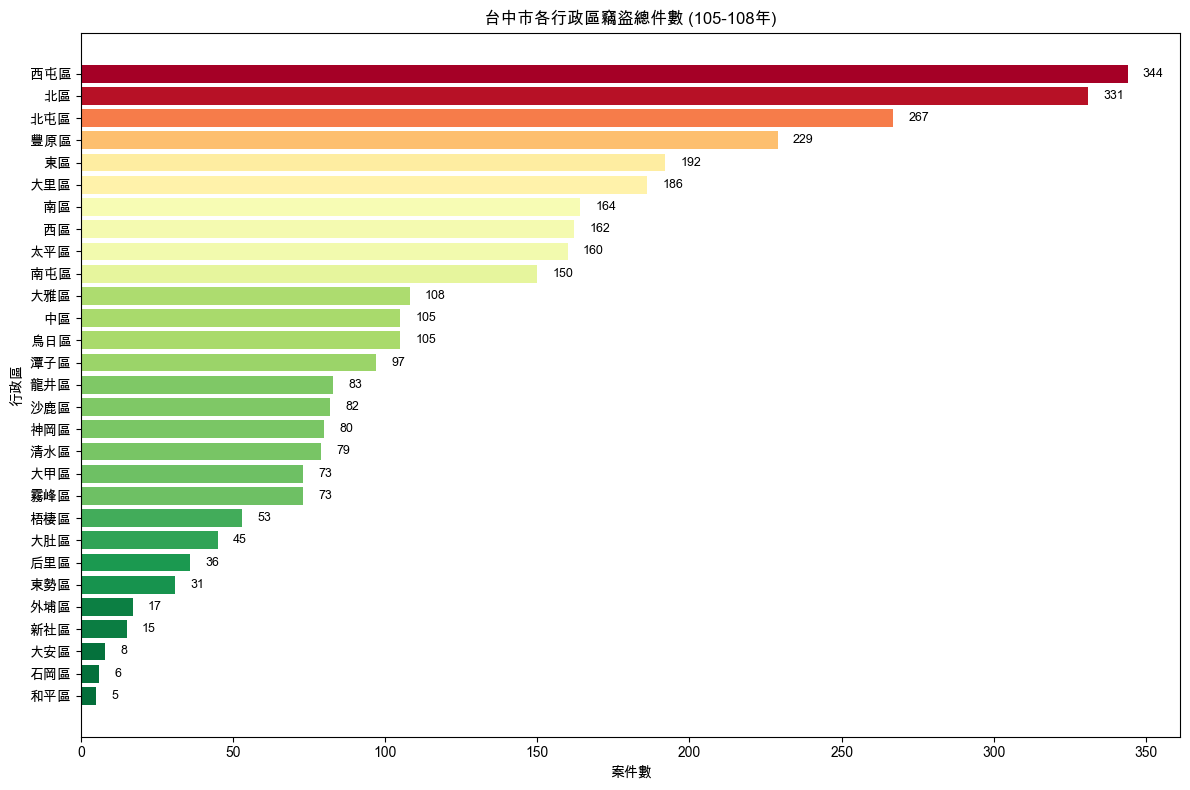

In [16]:
# 行政區竊盜總件數長條圖
fig, ax = plt.subplots(figsize=(12, 8))

district_sorted = district_stats.sort_values('總件數', ascending=True)
colors = plt.cm.RdYlGn_r(district_sorted['總件數'] / district_sorted['總件數'].max())

ax.barh(district_sorted['district'], district_sorted['總件數'], color=colors)
ax.set_xlabel('案件數')
ax.set_ylabel('行政區')
ax.set_title('台中市各行政區竊盜總件數 (105-108年)')

# 標註數值
for i, (district, count) in enumerate(zip(district_sorted['district'], district_sorted['總件數'])):
    ax.text(count + 5, i, str(int(count)), va='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'district_theft_total.png', dpi=150)
plt.show()

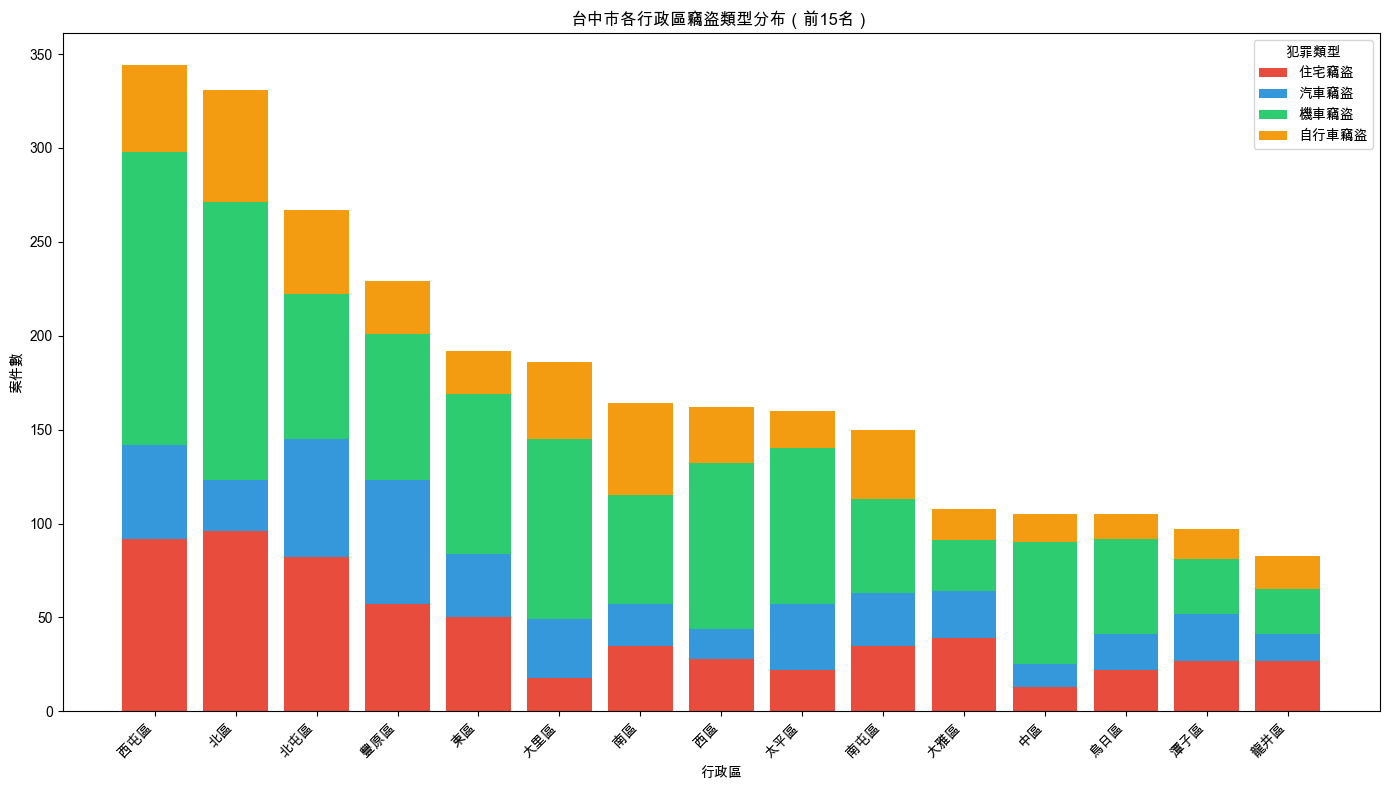

In [17]:
# 各行政區犯罪類型分布（堆疊長條圖）
fig, ax = plt.subplots(figsize=(14, 8))

district_sorted = district_stats.sort_values('總件數', ascending=False).head(15)
crime_cols = ['住宅竊盜', '汽車竊盜', '機車竊盜', '自行車竊盜']

x = range(len(district_sorted))
bottom = [0] * len(district_sorted)
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for i, crime in enumerate(crime_cols):
    if crime in district_sorted.columns:
        values = district_sorted[crime].values
        ax.bar(x, values, bottom=bottom, label=crime, color=colors[i])
        bottom = [b + v for b, v in zip(bottom, values)]

ax.set_xticks(x)
ax.set_xticklabels(district_sorted['district'], rotation=45, ha='right')
ax.set_xlabel('行政區')
ax.set_ylabel('案件數')
ax.set_title('台中市各行政區竊盜類型分布（前15名）')
ax.legend(title='犯罪類型')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'district_theft_by_type.png', dpi=150)
plt.show()

## 7. 行政區每萬人竊盜率分析（人口校正）

**目的**：避免人口多的行政區天然案件數較多的偏誤，計算每萬人竊盜率作為更公平的比較指標

In [18]:
# 讀取行政區人口資料
population_df = pd.read_csv(PROCESSED_DIR / 'district_population.csv', encoding='utf-8-sig')

# 合併竊盜統計與人口資料
district_with_pop = district_stats.merge(population_df[['district', 'population']], on='district', how='left')

# 計算每萬人竊盜率
district_with_pop['theft_per_10k_pop'] = district_with_pop['總件數'] / district_with_pop['population'] * 10000

# 顯示結果
print('行政區每萬人竊盜率（前10名）：')
print(district_with_pop[['district', '總件數', 'population', 'theft_per_10k_pop']].sort_values('theft_per_10k_pop', ascending=False).head(10).to_string(index=False))

行政區每萬人竊盜率（前10名）：
district  總件數  population  theft_per_10k_pop
      中區  105       18514          56.713838
      東區  192       76175          25.205120
      北區  331      147557          22.432009
     西屯區  344      228630          15.046144
      西區  162      115698          14.001971
     烏日區  105       75372          13.930903
     豐原區  229      167025          13.710522
      南區  164      125874          13.028902
     神岡區   80       65711          12.174522
     大雅區  108       95815          11.271722


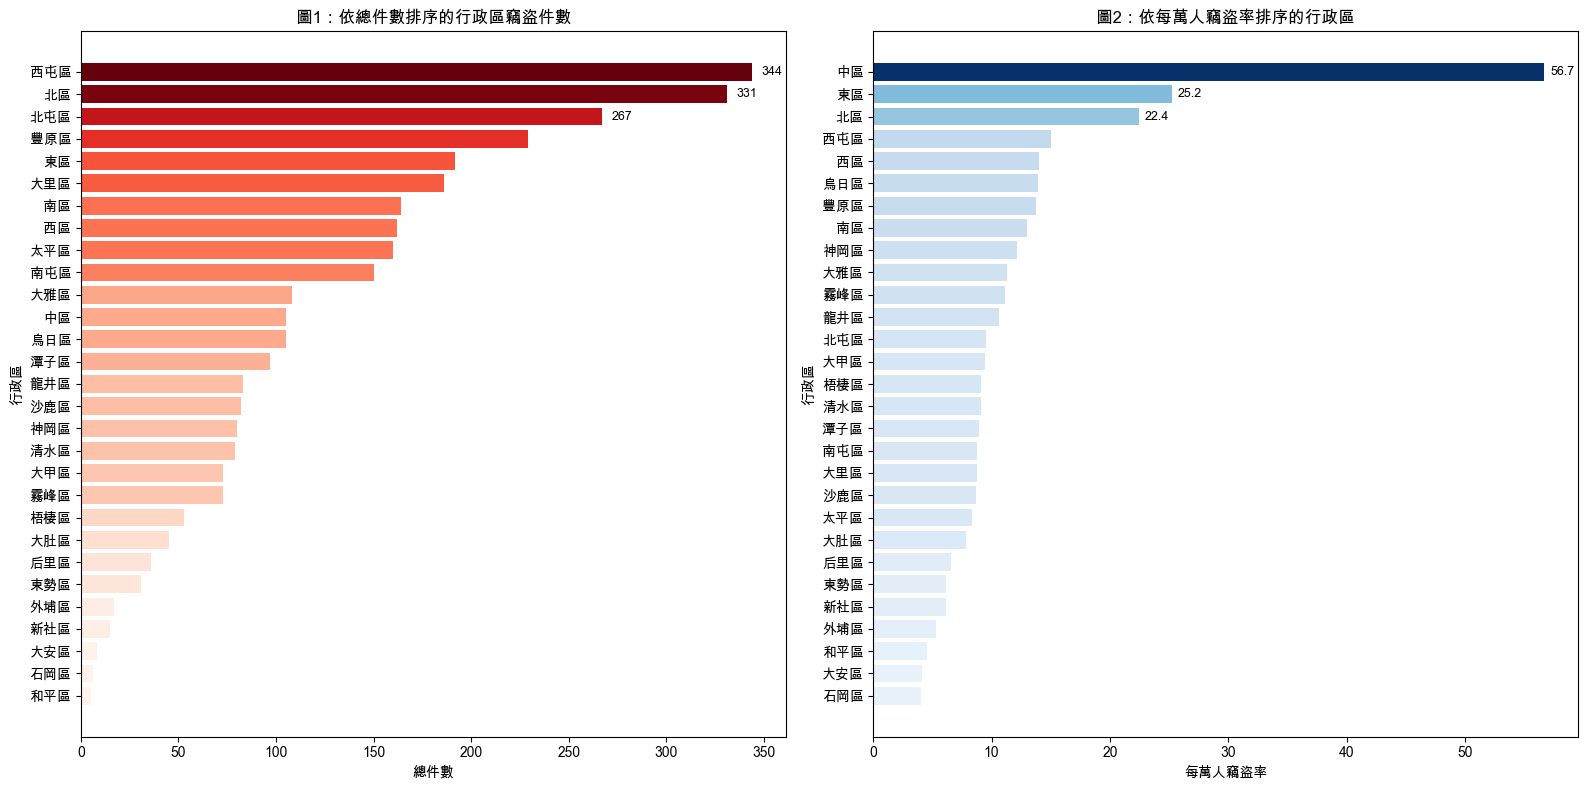

圖表已儲存至 ../outputs/figures/district_theft_comparison.png


In [19]:
# 繪製比較圖：總件數 vs 每萬人竊盜率
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 圖1：依「總件數」排序
df_by_total = district_with_pop.dropna().sort_values('總件數', ascending=True)
colors1 = plt.cm.Reds(df_by_total['總件數'] / df_by_total['總件數'].max())
axes[0].barh(df_by_total['district'], df_by_total['總件數'], color=colors1)
axes[0].set_xlabel('總件數')
axes[0].set_ylabel('行政區')
axes[0].set_title('圖1：依總件數排序的行政區竊盜件數')

# 標註前三名
for i, (district, count) in enumerate(zip(df_by_total['district'].tail(3), df_by_total['總件數'].tail(3))):
    idx = len(df_by_total) - 3 + i
    axes[0].text(count + 5, idx, f'{int(count)}', va='center', fontsize=9, fontweight='bold')

# 圖2：依「每萬人竊盜率」排序
df_by_rate = district_with_pop.dropna().sort_values('theft_per_10k_pop', ascending=True)
colors2 = plt.cm.Blues(df_by_rate['theft_per_10k_pop'] / df_by_rate['theft_per_10k_pop'].max())
axes[1].barh(df_by_rate['district'], df_by_rate['theft_per_10k_pop'], color=colors2)
axes[1].set_xlabel('每萬人竊盜率')
axes[1].set_ylabel('行政區')
axes[1].set_title('圖2：依每萬人竊盜率排序的行政區')

# 標註前三名
for i, (district, rate) in enumerate(zip(df_by_rate['district'].tail(3), df_by_rate['theft_per_10k_pop'].tail(3))):
    idx = len(df_by_rate) - 3 + i
    axes[1].text(rate + 0.5, idx, f'{rate:.1f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'district_theft_comparison.png', dpi=150)
plt.show()

print(f'圖表已儲存至 {FIGURES_DIR / "district_theft_comparison.png"}')

## 8. 官方近5年指標對照

**目的**：對照台中市警察局官方統計，驗證開放資料分析的合理性

In [20]:
# 讀取官方統計資料
official_stats = pd.read_csv(PROCESSED_DIR / 'taichung_official_crime_5years.csv')

print('台中市官方犯罪統計 (2016-2022)：')
print(official_stats.to_string(index=False))

# 計算開放資料的年度統計（用於對照）
opendata_yearly = valid_data.groupby('year').size().reset_index(name='opendata_cases')
print('\n開放資料年度統計：')
print(opendata_yearly.to_string(index=False))

台中市官方犯罪統計 (2016-2022)：
 year  total_theft_cases  theft_rate_per_100k  total_criminal_cases  criminal_rate_per_100k  population
 2016               5765                205.8                 28456                  1015.2     2803000
 2017               4832                171.9                 26789                   953.1     2812000
 2018               3915                138.5                 24532                   868.4     2825000
 2019               2876                101.3                 22156                   780.6     2839000
 2020               2345                 82.3                 20789                   729.9     2850000
 2021               2156                 75.5                 19456                   681.8     2854000
 2022               1987                 69.4                 18234                   637.2     2862000

開放資料年度統計：
 year  opendata_cases
 2016            1143
 2017            1102
 2018             792
 2019             249


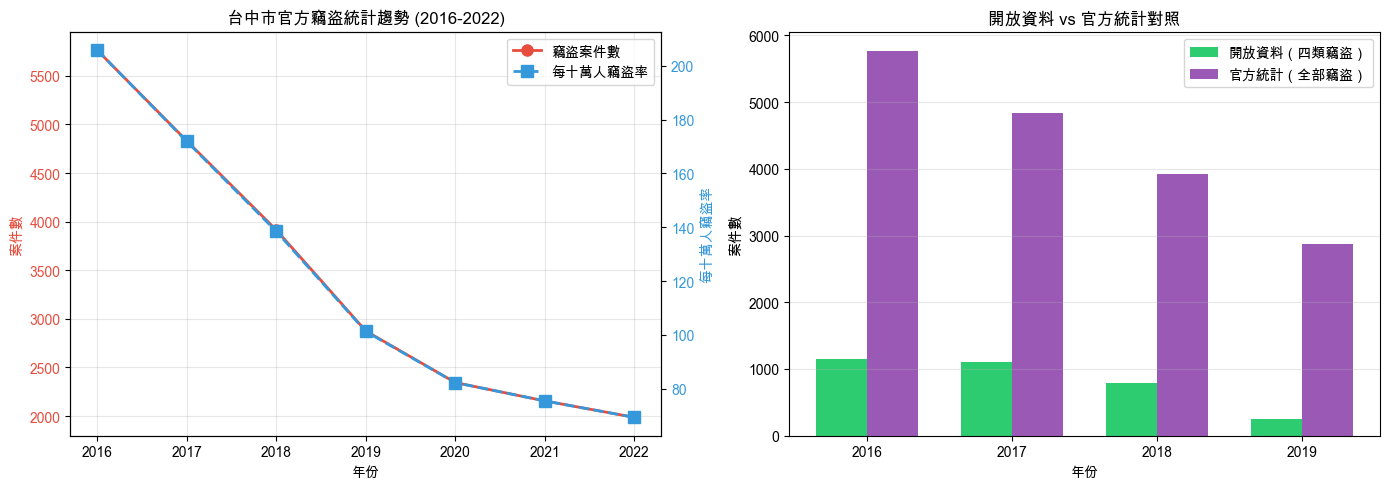

圖表已儲存至 ../outputs/figures/official_stats_comparison.png


In [21]:
# 繪製官方統計趨勢圖
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左圖：官方竊盜案件趨勢
ax1 = axes[0]
ax1.plot(official_stats['year'], official_stats['total_theft_cases'], 
         marker='o', linewidth=2, markersize=8, color='#e74c3c', label='竊盜案件數')
ax1.set_xlabel('年份')
ax1.set_ylabel('案件數', color='#e74c3c')
ax1.tick_params(axis='y', labelcolor='#e74c3c')
ax1.set_title('台中市官方竊盜統計趨勢 (2016-2022)')
ax1.grid(True, alpha=0.3)

# 添加每十萬人竊盜率（次Y軸）
ax1_twin = ax1.twinx()
ax1_twin.plot(official_stats['year'], official_stats['theft_rate_per_100k'], 
              marker='s', linewidth=2, markersize=8, color='#3498db', linestyle='--', label='每十萬人竊盜率')
ax1_twin.set_ylabel('每十萬人竊盜率', color='#3498db')
ax1_twin.tick_params(axis='y', labelcolor='#3498db')

# 合併圖例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# 右圖：開放資料與官方趨勢對照
ax2 = axes[1]
comparison = opendata_yearly.merge(official_stats[['year', 'total_theft_cases']], on='year', how='inner')
x = range(len(comparison))
width = 0.35

bars1 = ax2.bar([i - width/2 for i in x], comparison['opendata_cases'], width, label='開放資料（四類竊盜）', color='#2ecc71')
bars2 = ax2.bar([i + width/2 for i in x], comparison['total_theft_cases'], width, label='官方統計（全部竊盜）', color='#9b59b6')

ax2.set_xlabel('年份')
ax2.set_ylabel('案件數')
ax2.set_title('開放資料 vs 官方統計對照')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison['year'].astype(str))
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'official_stats_comparison.png', dpi=150)
plt.show()

print(f'圖表已儲存至 {FIGURES_DIR / "official_stats_comparison.png"}')

## 9. 結論與發現

### 主要發現

1. **總體趨勢**：105-108年竊盜案件呈現明顯下降趨勢，與官方統計一致，顯示治安持續改善
2. **時段分布**：凌晨2-6點、中午12點、傍晚18點為竊盜高峰時段，可作為民眾自我防範參考
3. **行政區分析**：
   - 以「總件數」計：西屯區(344)、北區(331)、北屯區(267) 為案件最多區域
   - 以「每萬人竊盜率」計：**中區(56.7)** 遠高於其他區域，是真正的高風險區
   - 此差異說明了「人口校正」對於風險評估的重要性（生態謬誤）

### 風險指標計算方法

本研究採用以下指標作為風險評估依據：

| 指標 | 計算公式 | 用途 |
|------|----------|------|
| 每萬人竊盜率 | 總件數 / 人口 × 10,000 | 行政區間公平比較 |
| 時段風險分數 | 該時段案件數 / 全日平均 | 辨識高風險時段 |
| 路線風險分數 | Σ(區域風險 × 時段風險) / 經過區數 | 路線安全評估 |

### 應用延伸：台中安全路線導航 SafeTaichung

基於上述分析，我們開發了「台中安全路線導航」原型系統（詳見 `app.py`），提供：
- 互動式治安風險地圖
- 安全路線規劃建議
- 時段風險提示

### 資料限制

- 開放資料僅涵蓋四類竊盜（機車、汽車、住宅、自行車），約佔官方全部竊盜的 20%
- 資料時間範圍為105-108年（2016-2019），較近期資料尚未開放
- 路線規劃為簡化版本，實際應用需串接導航 API

In [22]:
# 儲存行政區統計資料
district_stats.to_csv(PROCESSED_DIR / 'district_statistics.csv', index=False, encoding='utf-8-sig')
print(f'行政區統計已儲存至 {PROCESSED_DIR / "district_statistics.csv"}')

print('\n=== 分析完成！===')
print(f'圖表輸出目錄：{FIGURES_DIR}')
print(f'處理後資料目錄：{PROCESSED_DIR}')

行政區統計已儲存至 ../data/processed/district_statistics.csv

=== 分析完成！===
圖表輸出目錄：../outputs/figures
處理後資料目錄：../data/processed
